In [ ]:
!pip install pycocotools

# Set up training and test data set using Kaggle's COCO caption dataset

In [30]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CocoCaptions
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from transformers import GPT2Tokenizer, GPT2LMHeadModel, CLIPProcessor, CLIPModel, AdamW
from torch.nn.utils.rnn import pad_sequence
import json# Install pycocotools
import random

def collate(batch):
    images, captions = zip(*batch)  # Unpack images and captions
    images = torch.stack(images, dim=0)  # Stack images into a tensor

    # Process captions - assuming these are strings and we are directly tokenizing them here
    processed_captions = [caption[0] if isinstance(caption, (list, tuple)) else caption for caption in captions]

    return images, processed_captions

class LimitedCocoCaptions(CocoCaptions):
    def __init__(self, root, annFile, transform=None, target_transform=None, transforms=None, limit=6000):
        super().__init__(root, annFile, transform, target_transform, transforms)
        self.limit = limit
        self.indices = list(range(len(self)))  # Get all indices
        random.shuffle(self.indices)  # Shuffle the indices
        self.indices = self.indices[:limit]  # Select the first `limit` indices

    def __len__(self):
        return min(self.limit, super().__len__())

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]  # Get the actual index from the shuffled list
        return super().__getitem__(actual_idx)



# Paths to the dataset
data_dir = '/kaggle/input/coco-image-caption'  # Adjust this to the correct path
ann_file_train = f'{data_dir}/annotations_trainval2014/annotations/captions_train2014.json'
img_dir_train = f'{data_dir}/train2014/train2014/'

# Define the transforms for the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load the limited COCO training dataset
dataset = LimitedCocoCaptions(root=img_dir_train, annFile=ann_file_train, transform=transform, limit=2500)

# Split the dataset into training and test sets (80-20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create a DataLoader for the dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate)


loading annotations into memory...
Done (t=1.05s)
creating index...
index created!


# Set up Transformer Architecture

In [31]:

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, num_tokens, num_layers=6, num_heads=8, ff_dim=2048, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, input_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(input_dim, num_tokens)
        self.dropout = nn.Dropout(dropout)
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.output_layer(self.dropout(x))
        return x

# Get pretrained GPT2 model and freeze all but the last two layers

In [32]:
# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Freeze all layers except the last few
num_layers_to_freeze = 10
for param in gpt2_model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers
for param in gpt2_model.transformer.h[num_layers_to_freeze:].parameters():
    param.requires_grad = True

# Additionally, ensure that the language modeling head is trainable
for param in gpt2_model.lm_head.parameters():
    param.requires_grad = True

# Verify the freezing
for name, param in gpt2_model.named_parameters():
    print(name, param.requires_grad)

tokenizer.pad_token = tokenizer.eos_token

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt2_model.to(device)  # Move GPT-2 model to the device

transformer.wte.weight True
transformer.wpe.weight False
transformer.h.0.ln_1.weight False
transformer.h.0.ln_1.bias False
transformer.h.0.attn.c_attn.weight False
transformer.h.0.attn.c_attn.bias False
transformer.h.0.attn.c_proj.weight False
transformer.h.0.attn.c_proj.bias False
transformer.h.0.ln_2.weight False
transformer.h.0.ln_2.bias False
transformer.h.0.mlp.c_fc.weight False
transformer.h.0.mlp.c_fc.bias False
transformer.h.0.mlp.c_proj.weight False
transformer.h.0.mlp.c_proj.bias False
transformer.h.1.ln_1.weight False
transformer.h.1.ln_1.bias False
transformer.h.1.attn.c_attn.weight False
transformer.h.1.attn.c_attn.bias False
transformer.h.1.attn.c_proj.weight False
transformer.h.1.attn.c_proj.bias False
transformer.h.1.ln_2.weight False
transformer.h.1.ln_2.bias False
transformer.h.1.mlp.c_fc.weight False
transformer.h.1.mlp.c_fc.bias False
transformer.h.1.mlp.c_proj.weight False
transformer.h.1.mlp.c_proj.bias False
transformer.h.2.ln_1.weight False
transformer.h.2.ln_1.

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# Get pretrained CLIP model

In [33]:
# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", do_rescale=False)

# Train and test

In [34]:
# Initialize the Transformer encoder
transformer_encoder = TransformerEncoder(input_dim=clip_model.config.projection_dim, num_tokens=gpt2_model.config.vocab_size).to(device)

# Initialize the optimizer
optimizer = torch.optim.AdamW(list(gpt2_model.parameters()) + list(transformer_encoder.parameters()), lr=5e-5)

# Lists to store training and test losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(12):  # Adjust the number of epochs here
    gpt2_model.train()
    transformer_encoder.train()
    train_loss = 0
    
    for batch in train_loader:
        optimizer.zero_grad()

        # Move data to the correct device
        images = batch[0].to(device)  # Image tensors
        captions = batch[1]  # Caption data

        # Preprocess images with CLIP to get image embeddings
        inputs = clip_processor(images=images, return_tensors="pt").to(device)
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Ensure all inputs are on the correct device
        image_embeddings = clip_model.get_image_features(**inputs)
        #image_embeddings = clip_model.get_image_features(images)  # Corrected line

        # Tokenize captions for use with GPT-2
        inputs = tokenizer(captions, return_tensors="pt", padding=True, truncation=True)
        input_ids = inputs.input_ids.to(device)  # Tokenized text input IDs

        # Map image embeddings to token logits using the transformer encoder
        token_logits = transformer_encoder(image_embeddings)

        # Generate text from the token logits using GPT-2
        outputs = gpt2_model(
            input_ids=input_ids,
            labels=input_ids
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Loss: {loss.item()}")
        train_loss += loss.item()

    # Calculate average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluate on the test set
    gpt2_model.eval()
    transformer_encoder.eval()
    test_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            # Move data to the correct device
            images = batch[0].to(device)
            captions = batch[1]

            # Preprocess images with CLIP
            inputs = clip_processor(images=images, return_tensors="pt").to(device)
            inputs = {k: v.to(device) for k, v in inputs.items()}  # Ensure all inputs are on the correct device
            image_embeddings = clip_model.get_image_features(**inputs)

            # Map image embeddings to token logits using the transformer encoder
            token_logits = transformer_encoder(image_embeddings)

            # Prepare GPT-2 input
            input_ids = tokenizer(captions, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)

            # Generate text from the token logits using GPT-2
            outputs = gpt2_model(
                input_ids=input_ids,
                labels=input_ids
            )

            loss = outputs.loss
            test_loss += loss.item()

    # Calculate average test loss
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")



Epoch: 0, Loss: 6.962311267852783
Epoch: 0, Loss: 6.337734699249268
Epoch: 0, Loss: 9.608268737792969
Epoch: 0, Loss: 6.286168098449707
Epoch: 0, Loss: 6.682429790496826
Epoch: 0, Loss: 6.9172844886779785
Epoch: 0, Loss: 6.28126335144043
Epoch: 0, Loss: 5.844742774963379
Epoch: 0, Loss: 5.691717624664307
Epoch: 0, Loss: 5.688540458679199
Epoch: 0, Loss: 5.554533958435059
Epoch: 0, Loss: 5.293516159057617
Epoch: 0, Loss: 5.116582870483398
Epoch: 0, Loss: 5.185474872589111
Epoch: 0, Loss: 5.036556720733643
Epoch: 0, Loss: 4.860733509063721
Epoch: 0, Loss: 4.709133625030518
Epoch: 0, Loss: 4.236293792724609
Epoch: 0, Loss: 4.067302703857422
Epoch: 0, Loss: 3.711430549621582
Epoch: 0, Loss: 3.7451114654541016
Epoch: 0, Loss: 3.5097217559814453
Epoch: 0, Loss: 3.024202346801758
Epoch: 0, Loss: 3.4411933422088623
Epoch: 0, Loss: 3.144876480102539
Epoch: 0, Loss: 2.7152812480926514
Epoch: 0, Loss: 2.9329748153686523
Epoch: 0, Loss: 1.459926724433899
Epoch: 0, Loss: 2.8627054691314697
Epoch: 0

# Plot training and test loss curves

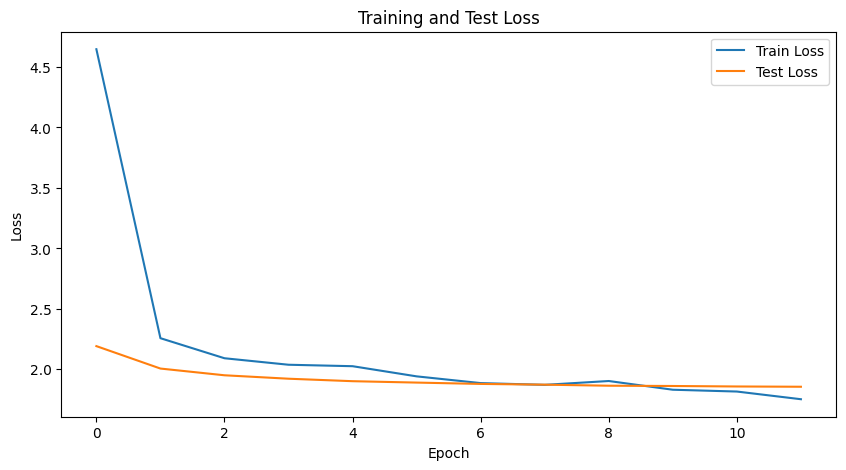

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Generate a prompt from an image

In [38]:
from PIL import Image

def generate_prompt_from_image(image_path):
    # Preprocess the image using CLIP processor
    image = Image.open(image_path).convert('RGB')
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Ensure all inputs are on the correct device

    # Get image embeddings from CLIP
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(**inputs)

    # Map image embeddings to token logits using the transformer encoder
    token_logits = transformer_encoder(image_embeddings)

    # Get the indices of the top 5 elements
    topk_values, topk_indices = torch.topk(token_logits, 1, dim=-1)

    # Select the top 5 token IDs
    token_ids = topk_indices.squeeze(0).unsqueeze(0)  # Add batch dimension
    print(token_ids)

    # Generate text prompt using GPT-2
    generated_ids = gpt2_model.generate(input_ids=token_ids, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
    prompt = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return prompt

# Example usage
image_path = "/kaggle/input/seal-image/test_image2.png"
generated_prompt = generate_prompt_from_image(image_path)
print(generated_prompt)


tensor([[40252]], device='cuda:0')
baby and a dog sitting on top of a couch.


#  Get cosine similarity score from generated prompt

In [42]:
!pip install sentence-transformers

# Example usage
image_path = "/kaggle/input/seal-image/test_image2.png"
generated_prompt = generate_prompt_from_image(image_path)
print(generated_prompt)

from sentence_transformers import SentenceTransformer, util

reference_text = "photo of a seal balancing on a beach ball while balancing a beach ball on its nose in someone's backyard by an above ground swimming pool"

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode([reference_text, generated_prompt])
similarity = util.cos_sim(embeddings[0], embeddings[1])
print(f"Cosine Similarity: {similarity.item()}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tensor([[40252]], device='cuda:0')
baby and a dog sitting on top of a couch.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity: 0.0059972102753818035
